<a href="https://colab.research.google.com/github/djsg2021utec/TESIS_MAESTRIA/blob/main/Filtros_de_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

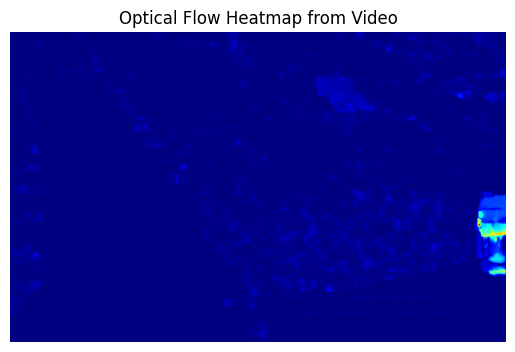

'/mnt/data/optical_flow_heatmap_video.png'

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Cargamos el video proporcionado por el usuario
video_path = '/content/descarga (3).mp4'
cap = cv2.VideoCapture(video_path)

# Leemos los dos primeros frames del video
ret, frame1 = cap.read()
ret, frame2 = cap.read()

# Convertimos los frames a escala de grises
prvs = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
next = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

# Calculamos el flujo óptico utilizando el algoritmo Farneback
flow = cv2.calcOpticalFlowFarneback(prvs, next, None, 0.5, 3, 15, 3, 5, 1.2, 0)

# Obtenemos la magnitud y el ángulo del flujo
magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])

# Normalizamos la magnitud para que esté entre 0 y 255
magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)

# Aplicamos un mapa de calor a la magnitud normalizada del flujo óptico
heat_map = cv2.applyColorMap(np.uint8(magnitude), cv2.COLORMAP_JET)

# Guardamos la imagen resultante del mapa de calor
output_path_heatmap = '/mnt/data/optical_flow_heatmap_video.png'
cv2.imwrite(output_path_heatmap, heat_map)

# Mostramos la imagen resultante
plt.imshow(cv2.cvtColor(heat_map, cv2.COLOR_BGR2RGB))
plt.title('Optical Flow Heatmap from Video')
plt.axis('off')
plt.show()

# Liberamos el capturador de video
cap.release()

output_path_heatmap


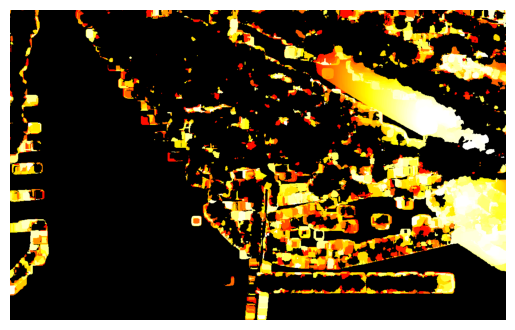

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Función para procesar un video y resaltar los bordes y el movimiento
def process_video(video_path, output_path):
    cap = cv2.VideoCapture(video_path)
    ret, prev_frame = cap.read()

    # Convertimos el primer frame a escala de grises y encontramos los bordes
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    prev_edges = cv2.Canny(prev_gray, threshold1=50, threshold2=100)

    # Inicializamos la imagen de flujo óptico acumulado
    h, w = prev_gray.shape[:2]
    motion_history = np.zeros((h, w), dtype=np.float32)

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Convertimos el frame a escala de grises y detectamos bordes
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray, threshold1=50, threshold2=100)

        # Calculamos el flujo óptico entre los bordes del frame actual y el anterior
        flow = cv2.calcOpticalFlowFarneback(prev_edges, edges, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        magnitude, _ = cv2.cartToPolar(flow[..., 0], flow[..., 1])

        # Actualizamos el historial de movimiento sólo en áreas con movimiento significativo
        motion_history = np.maximum(motion_history - 1, 0)  # Decaimiento
        motion_history[magnitude > 1.0] = 255  # Resaltar movimiento

        # Preparamos el siguiente ciclo
        prev_edges = edges

    cap.release()

    # Normalizamos el historial de movimiento
    motion_history_norm = cv2.normalize(motion_history, None, 0, 255, cv2.NORM_MINMAX)

    # Aplicamos un mapa de calor al historial de movimiento normalizado
    motion_heatmap = cv2.applyColorMap(motion_history_norm.astype(np.uint8), cv2.COLORMAP_HOT)

    # Guardamos el mapa de calor
    cv2.imwrite(output_path, motion_heatmap)

# Ruta al archivo de video y a la salida del mapa de calor
video_path = '/content/descarga (3).mp4'
output_path = 'tu_salida.png'

# Procesamos el video
process_video(video_path, output_path)

# Mostramos el resultado
motion_heatmap = cv2.imread(output_path)
plt.imshow(cv2.cvtColor(motion_heatmap, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


In [ ]:
%%capture
%pip install ultralytics

import cv2
from ultralytics import YOLO

# Load the YOLOv8 model
model = YOLO('yolov8n.pt')

# Open the video file
video_path = "/content/descarga (3).mp4"
cap = cv2.VideoCapture(video_path)

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v') # or 'XVID' if .avi
fps = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter('/content/output_video.mp4', fourcc, fps, (frame_width, frame_height))

# Loop through the video frames
while cap.isOpened():
    # Read a frame from the video
    success, frame = cap.read()

    if success:
        # Run YOLOv8 tracking on the frame, persisting tracks between frames
        results = model.track(frame, classes=0, persist=True)

        # Visualize the results on the frame
        annotated_frame = results[0].plot()

        # Write the frame into the file 'output_video.mp4'
        out.write(annotated_frame)

        # Uncomment this line if you want to see the frame in Colab
        # cv2_imshow(annotated_frame)

        # Break the loop if 'q' is pressed (this won't work in Colab)
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
    else:
        # Break the loop if the end of the video is reached
        break

# Release everything when the job is finished
cap.release()
out.release()
cv2.destroyAllWindows()




0: 416x640 4 persons, 193.4ms
Speed: 3.5ms preprocess, 193.4ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 5 persons, 137.7ms
Speed: 6.4ms preprocess, 137.7ms inference, 1.9ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 2 persons, 137.1ms
Speed: 4.1ms preprocess, 137.1ms inference, 2.7ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 3 persons, 134.1ms
Speed: 5.6ms preprocess, 134.1ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 5 persons, 139.7ms
Speed: 4.3ms preprocess, 139.7ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 3 persons, 134.2ms
Speed: 3.6ms preprocess, 134.2ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 1 person, 137.5ms
Speed: 2.8ms preprocess, 137.5ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 2 persons, 143.1ms
Speed: 4.9ms preprocess, 143.1ms inference, 1.5ms postprocess per i

In [ ]:
results

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted p